# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import time
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, make_scorer)

import matplotlib.pyplot as plt
import seaborn as sns

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def load_data(path, y):
    X = []
    path = os.path.join(path, y)
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                X.append(np.array(img))
    
    return X, [y] * len(X)

In [3]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# Korišćenje skupa dobijenog automatskom obradom, pre ručne provere i relabeliranja

## Učitavanje i preprocesiranje podataka

In [4]:
images = []
labels = []
for i, label in enumerate(os.listdir('../../data/datasets/action_images_dataset_original_v1.0')):
    X, y = load_data('../../data/datasets/action_images_dataset_original_v1.0', label)
    images += X
    labels += y
images = np.array(images)

In [5]:
X = images.reshape((len(images), -1))
y = labels

In [6]:
class_labels = ['backhand', 'forehand', 'other', 'serve']

In [7]:
bh_cnt = sum([1 for l in y if l == 'backhand'])
fh_cnt = sum([1 for l in y if l == 'forehand'])
other_cnt = sum([1 for l in y if l == 'other'])
serve_cnt = sum([1 for l in y if l == 'serve'])
print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
print(f'All strokes count: {len(y)}')

Backhands count: 2038, Forehands count: 2412, Other count: 6217, Serve count: 1634
All strokes count: 12301


In [8]:
## Uncomment and run this cell with the desired num_examples count
## if you'd like to work with less data for testing purposes

# num_examples = 500
# X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=num_examples, stratify=y, random_state=42)
# X = X_sampled
# y = y_sampled

# bh_cnt = sum([1 for l in y if l == 'backhand'])
# fh_cnt = sum([1 for l in y if l == 'forehand'])
# other_cnt = sum([1 for l in y if l == 'other'])
# serve_cnt = sum([1 for l in y if l == 'serve'])
# print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
# print(f'All strokes count: {len(y)}')

## Isprobavanje metode potpornih vektora

**Napomena da je u celom projektu korišćeno determinističko razdvajanje na trening, validacioni i test skup (random_state=42), tako da je analiza test skupa pokrenuta tek na kraju celog projekta u svakoj svesci za svaki model.**

In [9]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, 
                                                                          test_size=0.1, 
                                                                          stratify=y, 
                                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

clf = SVC(kernel='rbf', gamma='scale', shrinking=True, random_state=7)
clf.fit(X_train, y_train)

SVC(random_state=7)

In [10]:
y_val_preds = clf.predict(X_val)
y_train_preds = clf.predict(X_train)

In [11]:
print("\nTraining set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))


Training set scores:
Accuracy: 0.8367208672086721
Precision: 0.8286767493920277
Recall: 0.8120797541217868
F1 Score: 0.8192965322854191

Validation set scores:
Accuracy: 0.8026196928635954
Precision: 0.7912238544748686
Recall: 0.7636365208369165
F1 Score: 0.7742205555060384


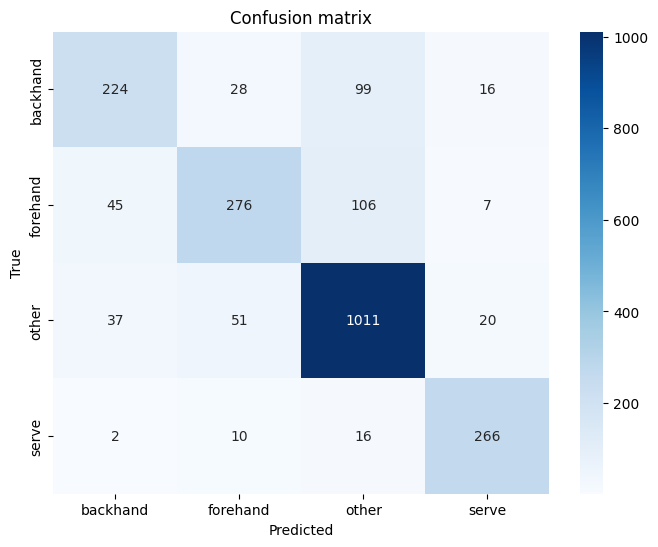

In [12]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.77      0.69      0.73      1467
    forehand       0.79      0.73      0.76      1737
       other       0.86      0.90      0.88      4476
       serve       0.90      0.93      0.92      1176

    accuracy                           0.84      8856
   macro avg       0.83      0.81      0.82      8856
weighted avg       0.83      0.84      0.83      8856



In [14]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.73      0.61      0.66       367
    forehand       0.76      0.64      0.69       434
       other       0.82      0.90      0.86      1119
       serve       0.86      0.90      0.88       294

    accuracy                           0.80      2214
   macro avg       0.79      0.76      0.77      2214
weighted avg       0.80      0.80      0.80      2214



## Pronalaženje najboljih hiperparametara

In [15]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y,
                                                                          test_size=0.2, 
                                                                          stratify=y, 
                                                                          random_state=42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

In [17]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'svc__C': [10**i for i in range(-2, 2)],
    'svc__kernel': ['sigmoid', 'rbf'],
    'svc__gamma': [10**i for i in range(-2, 2)],
}

grid_model = Pipeline(steps=[('scaler', StandardScaler()),
                             ('svc', SVC(random_state=42))])

### Analiza hiperparametara

In [18]:
start = time.time()

grid_params_svc = GridSearchCV(grid_model, param_grid=params, scoring='f1_macro', verbose=True,
                               cv=kf, return_train_score=True)#, n_jobs=60)
grid_params_svc.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Time taken: 00:07:41.80


In [19]:
best_model = grid_params_svc.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc.best_score_}")
print(f"Best parameters: {grid_params_svc.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.7278965851757202
Best parameters: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

Training set scores:
Accuracy: 0.9284806910569106
Precision: 0.9338350799373374
Recall: 0.9192227280038283
F1 Score: 0.9258815428365558

Validation set scores:
Accuracy: 0.9375
Precision: 0.9392514399739464
Recall: 0.9267520982437322
F1 Score: 0.9328212897585508


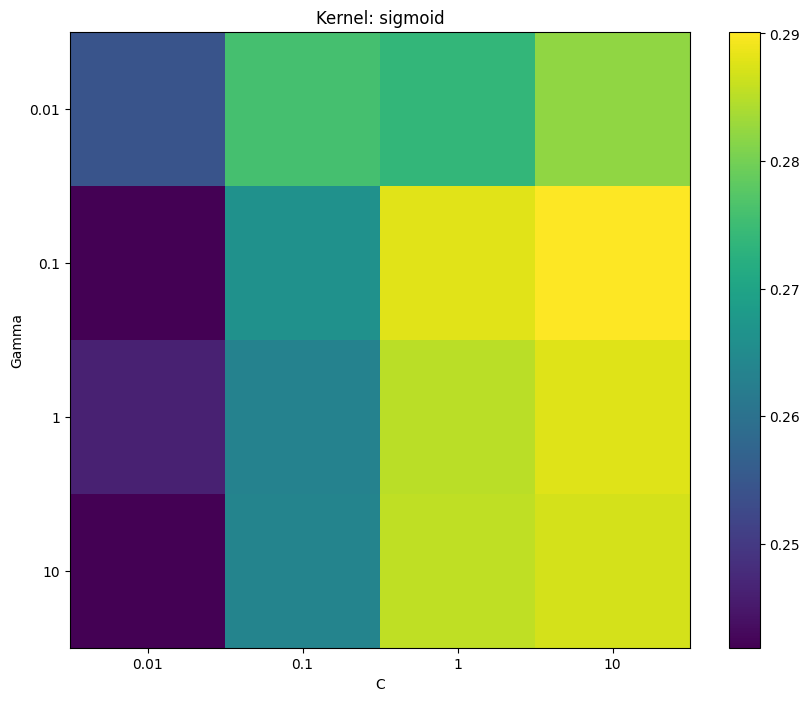

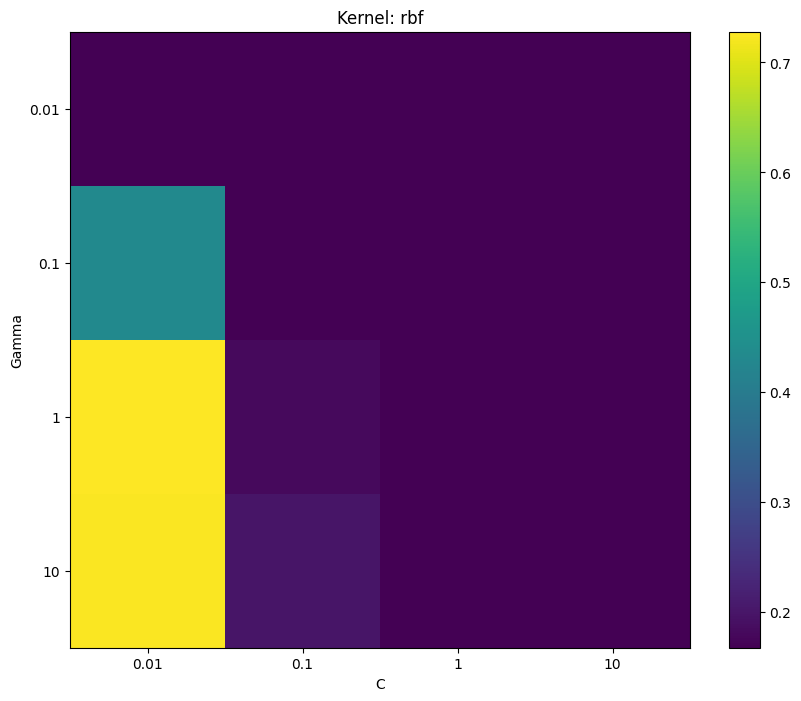

In [20]:
Cs = params['svc__C']
gammas = params['svc__gamma']
kernels = params['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

Sa plotova vidimo da su optimalne vrednosti hiperparametra `gamma` za različite kernele u različitom smeru. Jednom odgovaraju veće, jednom manje. Tako da ćemo u nastavku pokrenuti pretragu parametara za svaki kernel posebno.

### Za sigmoid kernel

In [21]:
start = time.time()

params_sig = {
    'svc__C': [10**i for i in range(0, 6)],
    'svc__kernel': ['sigmoid'],
    'svc__gamma': [10**i for i in range(-7, 1)],
}

grid_params_svc_sig = GridSearchCV(grid_model, param_grid=params_sig, scoring='f1_macro', verbose=True,
                                   cv=kf, return_train_score=True)#, n_jobs=60)
grid_params_svc_sig.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Time taken: 00:08:03.97


In [22]:
best_model = grid_params_svc_sig.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc_sig.best_score_}")
print(f"Best parameters: {grid_params_svc_sig.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.7592130118105356
Best parameters: {'svc__C': 100000, 'svc__gamma': 1e-06, 'svc__kernel': 'sigmoid'}

Training set scores:
Accuracy: 0.8236788617886179
Precision: 0.8158309371652147
Recall: 0.8037497419514099
F1 Score: 0.8090867704008377

Validation set scores:
Accuracy: 0.8307926829268293
Precision: 0.816140139777457
Recall: 0.811691940010556
F1 Score: 0.8133224889431503


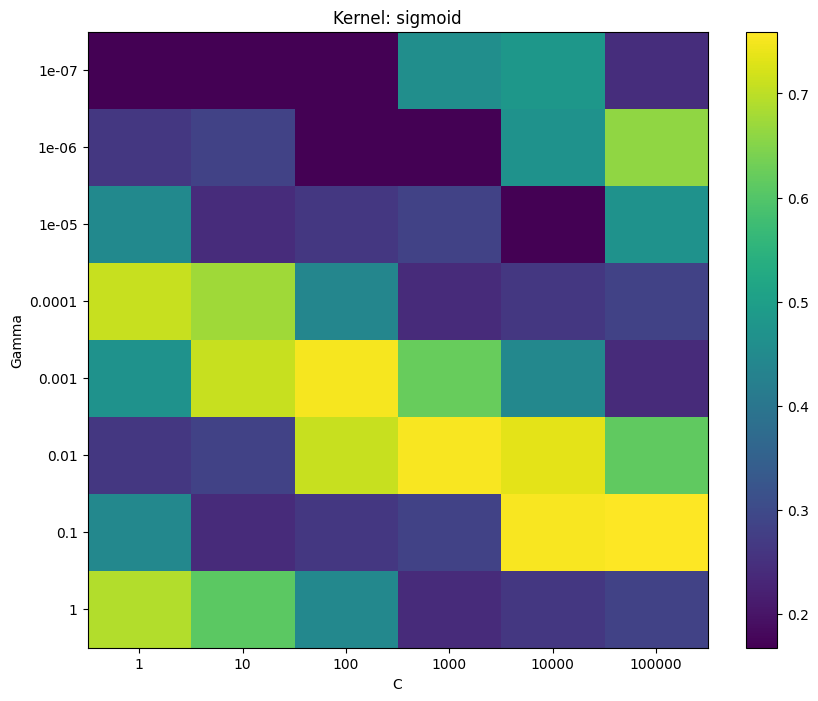

In [23]:
Cs = params_sig['svc__C']
gammas = params_sig['svc__gamma']
kernels = params_sig['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc_sig.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

### Za rbf kernel

In [25]:
start = time.time()

params_rbf = {
    'svc__C': [10**i for i in range(-1, 3)],
    'svc__kernel': ['rbf'],
    'svc__gamma': [10**i for i in range(-5, 1)],
}

grid_params_svc_rbf = GridSearchCV(grid_model, param_grid=params_rbf, scoring='f1_macro', verbose=True,
                                   cv=kf, return_train_score=True)#, n_jobs=60)
grid_params_svc_rbf.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Time taken: 00:07:41.48


In [26]:
best_model = grid_params_svc_rbf.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc_rbf.best_score_}")
print(f"Best parameters: {grid_params_svc_rbf.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.801153860689321
Best parameters: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Training set scores:
Accuracy: 0.8896087398373984
Precision: 0.8894446123276303
Recall: 0.8801445526243847
F1 Score: 0.884149317087989

Validation set scores:
Accuracy: 0.9009146341463414
Precision: 0.8992645094069848
Recall: 0.890612089290662
F1 Score: 0.8947518751093317


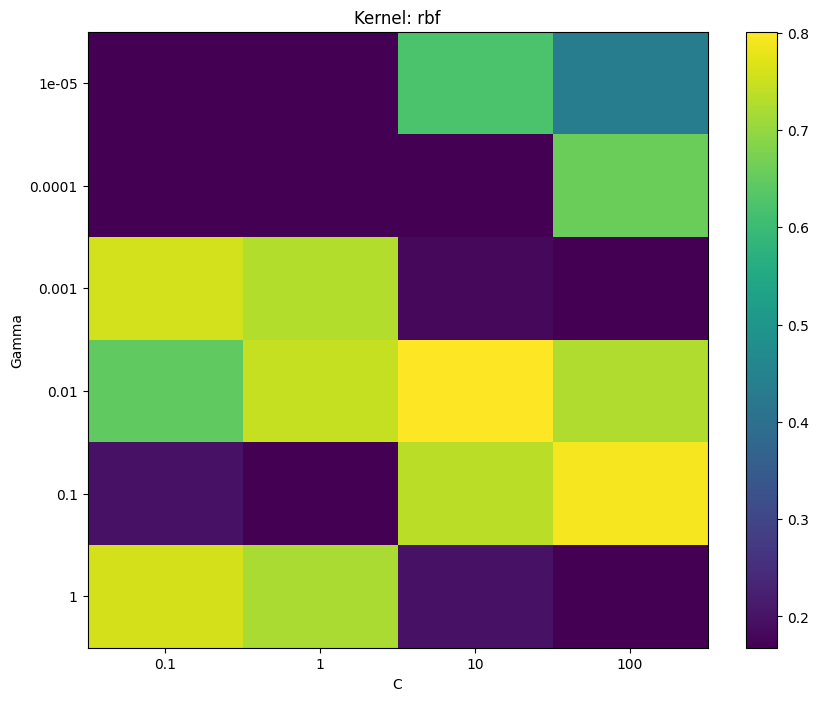

In [27]:
Cs = params_rbf['svc__C']
gammas = params_rbf['svc__gamma']
kernels = params_rbf['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc_rbf.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

Nakon analize oba kernela, biramo rbf i njegov najbolji model, tako da ove rezultate proglašavamo konačnim kvalitetom modela. Napomena kao i u ostalim slučajevima, neće biti treniran model nad svim podacima iz skupa (uključujući i test), nego će biti eksportovana verzija trenirana nad trening i validacionim skupom da bi se prilikom demonstracije ili bilo kog daljeg koraka mogli koristiti primeri iz test skupa i dobijala relevantna predviđanja.

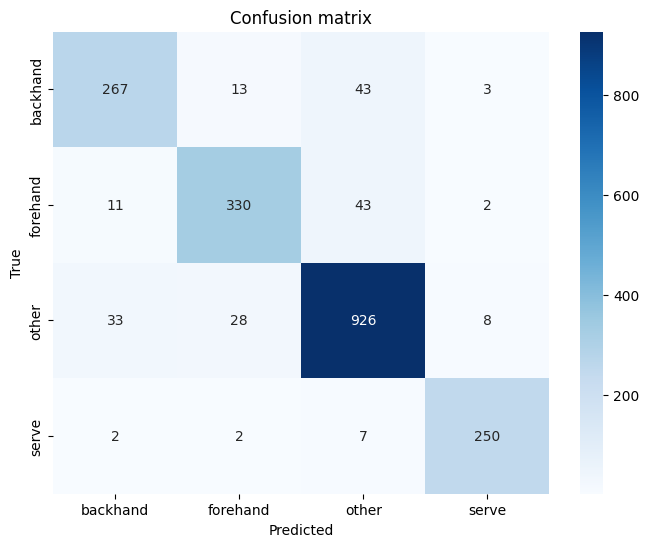

In [28]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.87      0.79      0.83      1304
    forehand       0.86      0.84      0.85      1544
       other       0.89      0.92      0.91      3978
       serve       0.93      0.97      0.95      1046

    accuracy                           0.89      7872
   macro avg       0.89      0.88      0.88      7872
weighted avg       0.89      0.89      0.89      7872



In [30]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.85      0.82      0.84       326
    forehand       0.88      0.85      0.87       386
       other       0.91      0.93      0.92       995
       serve       0.95      0.96      0.95       261

    accuracy                           0.90      1968
   macro avg       0.90      0.89      0.89      1968
weighted avg       0.90      0.90      0.90      1968



Možemo videti da se model ponaša prilično prihvatljivo što se generalizacije tiče. Naročito uzimajući u obzir to što ovaj skup sadrži dosta loše labeliranih primera.

## Procena modela na test skupu

In [31]:
y_test_preds = best_model.predict(X_test)

print("\nTest set scores:")
print("Accuracy:", accuracy_score(y_test, y_test_preds))
print("Precision:", precision_score(y_test, y_test_preds, average='macro'))
print("Recall:", recall_score(y_test, y_test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_preds, average='macro'))


Test set scores:
Accuracy: 0.8386834620073141
Precision: 0.8315305726427443
Recall: 0.8194911792962036
F1 Score: 0.8247038232092452


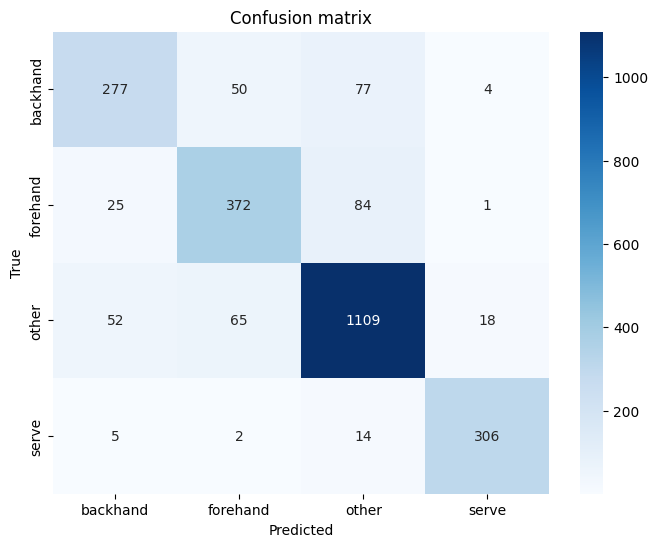

In [32]:
cm = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

    backhand       0.77      0.68      0.72       408
    forehand       0.76      0.77      0.77       482
       other       0.86      0.89      0.88      1244
       serve       0.93      0.94      0.93       327

    accuracy                           0.84      2461
   macro avg       0.83      0.82      0.82      2461
weighted avg       0.84      0.84      0.84      2461



Konačno, kao i u svim implementiranim slučajevima dobijamo nešto lošije rezultate za test skup, a opet kao u svakom slučaju, ovi rezultati su i više nego prihvatljivi uzimajući sve u obzir.

# Čuvanje modela, odnosno celog pipeline-a za kasniju upotrebu

In [34]:
import pickle

if not os.path.exists('../../models'):
    os.makedirs('../../models')
        
with open('../../models/02_svm_original_data.pkl', 'wb') as f:
    pickle.dump(best_model, f)